# <div align="center"> X-Rays识别 </div>

In [9]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
matplotlib 3.2.1
sklearn 0.23.1
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101


In [4]:
import pandas as pd  
import argparse      
import shutil        
import os            
import random
import numpy as np
import json

from tqdm import tqdm
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from IPython.display import display
from PIL import Image

from k12libs.utils.nb_dataset import k12ai_compute_mean_std

In [5]:
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'chestxray')
normal_images_raw = os.path.join(data_root, 'raw', 'chest_xray')
covid_images_raw = os.path.join(data_root, 'raw', 'covid-chestxray')
output_path = os.path.join(data_root, 'imgs')
normal_images_path = os.path.join(output_path, 'normal')
covid_images_path = os.path.join(output_path, 'covid')

## Covid-19数据处理

In [6]:
df = pd.read_csv(f'{covid_images_raw}/metadata.csv')
df[['finding', 'view', 'filename']]

,finding,view,filename
0,COVID-19,PA,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,COVID-19,PA,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,COVID-19,PA,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,COVID-19,PA,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,COVID-19,PA,nejmc2001573_f1a.jpeg
...,...,...,...
753,todo,AP Supine,7a9ec606.jpg
754,todo,PA,88859dc1.jpg
755,todo,PA,3a81faf3.jpg
756,todo,PA,bcb814aa.jpg


In [7]:
shutil.rmtree(covid_images_path)
os.makedirs(covid_images_path)

covid_images = []
for (i, row) in df.iterrows():
    if row['finding'] != 'COVID-19' or row['view'] != 'PA':
        continue
    image_path = os.path.join(covid_images_raw, 'images', row['filename'])
    if not os.path.exists(image_path):
        continue
    filename = image_path.split(os.path.sep)[-1]
    output_path = os.path.join(covid_images_path, filename)
    covid_images.append(output_path)
    shutil.copy2(image_path, output_path)
len(covid_images)

201

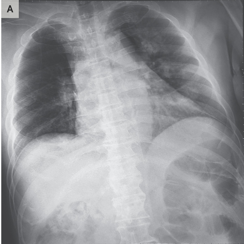

In [8]:
Image.open(covid_images[0]).resize((244, 244))

## Normal数据处理

In [9]:
# 随机图片len(covid_images)张图片, 形成平衡数据集
normal_images_all = []
with os.scandir(os.path.join(normal_images_raw, 'train', 'NORMAL')) as it:
    for entry in it:
        normal_images_all.append(entry.path) 
#
random.shuffle(normal_images_all)
print(len(normal_images_all))
normal_images_raw = normal_images_all[:len(covid_images)]
print(len(normal_images_raw))

1349
201


In [10]:
shutil.rmtree(normal_images_path)
os.makedirs(normal_images_path)

normal_images = []
for filepath in normal_images_raw:
    filename = filepath.split(os.path.sep)[-1]
    output_path = os.path.join(normal_images_path, filename)
    normal_images.append(output_path) 
    shutil.copy2(image_path, output_path)

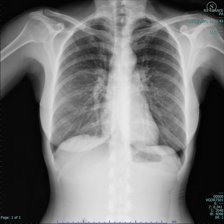

In [11]:
Image.open(normal_images[1]).resize((224, 224))

## 合成chestxray数据集

In [12]:
# 6:4:4 split for train:valid:test dataset
test_images = []
valid_images = []
train_images = []
for normal, covid in zip(normal_images, covid_images):
    value = random.random()
    if value > 0.8: # test
        test_images.append((normal, covid))
    elif value > 0.6: # val
        valid_images.append((normal, covid))
    else: # train
        train_images.append((normal, covid))
len(test_images), len(valid_images), len(train_images)

(44, 37, 120)

## 生成json文件

In [13]:
def gen_json_file(images, phase):
    prefix = len(data_root) + 1
    items = []
    for normal, covid in images:
        items.append({'image_path': normal[prefix:], 'label': 0})
        items.append({'image_path': covid[prefix:], 'label': 1})
        
    jsonfile = os.path.join(data_root, f'{phase}.json')
    with open(jsonfile, 'w') as fp:
        json.dump(items, fp)
        
# train.json
gen_json_file(train_images, 'train')

# val.json
gen_json_file(valid_images, 'val')

# test.json
gen_json_file(test_images, 'test')

In [14]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles, resize=(224, 224))

In [16]:
mean,std

(tensor([0.4857, 0.4854, 0.4882]), tensor([0.2438, 0.2433, 0.2442]))

## References

1. https://github.com/ieee8023/covid-chestxray-dataset/
2. https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
3. https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

In [15]:
#